In [1]:
import subprocess
import sys

def import_and_or_install(pkg):
    try:
        globals()[pkg] = __import__(pkg)
        print(f"Successfully imported {pkg}")
    except ImportError:
        print(f'Installation of {pkg} required')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])
        globals()[pkg] = __import__(pkg)  # Re-import after installation
        print(f"Successfully imported {pkg} after installation")

    return globals()[pkg]

In [2]:
lf = import_and_or_install("lifelines")
pd = import_and_or_install("pandas")

Successfully imported lifelines
Successfully imported pandas


In [3]:
#read file from csv file
loan_recoveries_df = pd.read_csv("loan_recoveries.csv")
loan_recoveries_df = loan_recoveries_df.fillna(0)
relevant_columns = ["past_due_days","event"] + ["age","education","Gender","Principal","terms"]
loan_recoveries_df = loan_recoveries_df[relevant_columns][loan_recoveries_df['event'] !=0]
loan_recoveries_df.head(10)

,past_due_days,event,age,education,Gender,Principal,terms
100,2,1,26,college,male,1000,30
101,4,1,28,college,male,1000,15
102,13,1,39,college,male,1000,30
103,5,1,29,Bechalor,male,1000,15
104,3,1,33,High School or Below,male,800,15
105,12,1,27,college,male,1000,30
106,2,1,34,college,male,800,15
107,27,1,26,High School or Below,male,1000,30
108,44,1,28,High School or Below,male,1000,30
109,5,1,32,Bechalor,male,1000,15


In [4]:
loan_recoveries_df.columns

Index(['past_due_days', 'event', 'age', 'education', 'Gender', 'Principal',
       'terms'],
      dtype='object')

In [5]:
loan_recoveries_df

,past_due_days,event,age,education,Gender,Principal,terms
100,2,1,26,college,male,1000,30
101,4,1,28,college,male,1000,15
102,13,1,39,college,male,1000,30
103,5,1,29,Bechalor,male,1000,15
104,3,1,33,High School or Below,male,800,15
...,...,...,...,...,...,...,...
195,3,1,28,High School or Below,male,1000,30
196,14,1,26,High School or Below,male,1000,15
197,3,1,30,college,male,800,15
198,1,1,38,college,female,1000,30


### Remapping DF to modify category columns accordingly

In [6]:
remapping_education = {"college":2,"High School or Below":1,"Master or Above":4,"Bechalor":3}
loan_recoveries_df["education"] = loan_recoveries_df["education"].apply(lambda val: remapping_education.get(val))
loan_recoveries_df["Gender"] = loan_recoveries_df["Gender"].apply(lambda gend: 1 if gend == "male" else 2)


loan_recoveries_df["past_due_days"] = loan_recoveries_df["past_due_days"].astype(float)
loan_recoveries_df.head(10)

,past_due_days,event,age,education,Gender,Principal,terms
100,2.0,1,26,2,1,1000,30
101,4.0,1,28,2,1,1000,15
102,13.0,1,39,2,1,1000,30
103,5.0,1,29,3,1,1000,15
104,3.0,1,33,1,1,800,15
105,12.0,1,27,2,1,1000,30
106,2.0,1,34,2,1,800,15
107,27.0,1,26,1,1,1000,30
108,44.0,1,28,1,1,1000,30
109,5.0,1,32,3,1,1000,15


In [7]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(loan_recoveries_df, duration_col='past_due_days', event_col='event')

<lifelines.CoxPHFitter: fitted with 100 total observations, 0 right-censored observations>

In [8]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 100 total observations, 0 right-censored observations>
             duration col = 'past_due_days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 100
number of events observed = 100
   partial log-likelihood = -361.74
         time fit was run = 2025-01-30 23:35:23 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.02           -0.02            0.05                0.98                1.05
education  0.10      1.10      0.15           -0.20            0.40                0.82                1.49
Gender     0.37      1.45      0.30           -0.22            0.96                0.80                2.60
Principal  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
terms     -0.01      0.99      0.02           -0.05            0.03                0.95                1.03

           cmp to     z    p  -log2(p)
covariate                             
age          0.00  0.79 0.43      1.23
education    0.00  0.64 0.52      0.93
Gender       0.00  1.23 0.22      2.20
Principal    0.00  0.07 0.94      0.08
terms        0.00 -0.56 0.58      0.79
---
Concordance = 0.61
Partial AIC = 733.47
log-likelihood ratio test = 4.01 on 5 df
-log2(p) of ll-ratio test = 0.87

### The p values indicate none of the columns are good indicators of past dues

<Axes: title={'center': 'Survival Curve for Loan Recovery of Target'}>

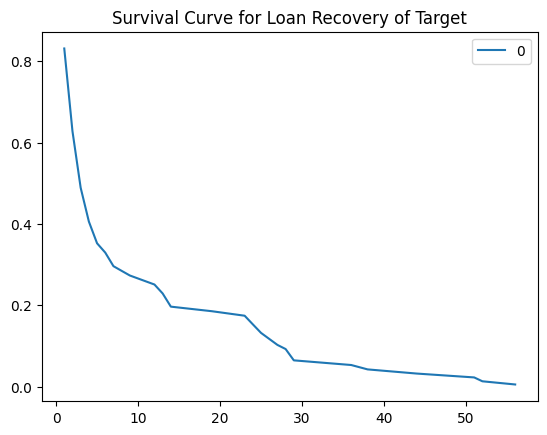

In [9]:
target = pd.DataFrame({'age':[30],'education':[2],'Principal':[1000], 'terms':[15], 'Gender':[1]})
survival_function = cph.predict_survival_function(target).dropna()
survival_function.plot(title = "Survival Curve for Loan Recovery of Target")

In [10]:
survival_function

,0
1.0,0.831280
2.0,0.627963
3.0,0.488917
4.0,0.405859
5.0,0.352373
6.0,0.329497
7.0,0.296127
8.0,0.284612
9.0,0.273209
12.0,0.251039


### We estimate the performance of the loan at median

In [18]:
median_days = cph.predict_median(target)
print(f" Median Days for recovery - {float(median_days)} Days")

 Median Days for recovery - 3.0 Days


### Another approach would be to assume a conservative estimate wherein x% of recoveries have occurred

In [19]:
prob_threshold_90 = 0.1 #90% recovery
survival_function_clean = survival_function.dropna()
recovery_days = survival_function_clean[survival_function_clean.values < prob_threshold_90]
recovery_days

,0
28.0,0.092408
29.0,0.064615
36.0,0.053171
38.0,0.042393
44.0,0.032146
51.0,0.022656
52.0,0.013156
56.0,0.005319


In [16]:
print(f"Recovery days estimate based where 90% are recovered  - {recovery_days.index.min()} Days")

Recovery days estimate based where 90% are recovered  - 28.0
